## Using R to investigate pairwise FST and nucleotide diversity  
Code adapted slightly from [Max Winston's scripts](https://github.com/mewinsto/Fst)  
This is just exploring one pair of populations. Will write up another notebook with looking at overall Fst and PCA in Adegenet.

An R script with this code can be found at my github [GBS_FST_Pi.R](https://raw.githubusercontent.com/ksil91/Scripts/master/FST/GBS_FST_Pi.R)

Requires: .geno file and .ind file containing 1 pair of populations. See [GBS_File_Conversions notebook](https://github.com/ksil91/2016_Notebook/blob/master/GBS_File_Conversions.ipynb) for code on how to get these files from a Structure (.str) formatted file.

In [1]:
setwd("~/Projects/Ostrea/over10k-min75H32/genos")
library("ggplot2")
library("reshape2")
library("dplyr")
library("repr")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Pairwise Fst is based on a modified Wright's FST estimator from [Chen et al.,2015](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0135368), where contributions to average FST is weighted by sample size.
![alt text](https://github.com/ksil91/2016_Notebook/raw/master/images/mewinso_fst.png "Fst estimator")
Currently, only SNPs that are genotyped in at least 2 individuals and do not have a MAF of 0 (within those 2 populations) are used to calculate average pairwise FST.

In [2]:
## Function to read in a .geno file. Returns a list with a matrix of genotypes, 
## a vector with population assignments for each individual (0 or 1), and
## a vector with randomized population assignments for sampling null.
makeGenoMatrix <- function(genofile, indfile){
    geno_data = scan(genofile,what = "character")
    L = length(geno_data)
    S = nchar(geno_data[[1]])
    geno_matrix = matrix(data = NA, nrow = S, ncol = L)
    for (i in 1:L){
        genostring = strsplit(geno_data[[i]], split="")
        for (j in 1:S){
        geno_matrix[j,i] = as.numeric(genostring[[1]][j])}
    }
    geno_matrix[geno_matrix == 9] = NA

    ##Read in .ind file in order to get population assignment for genotypes.
    testpop = read.table(indfile,header=FALSE)
    test_vector = testpop$V2
    test_sub = {}
    for (i in 1:S){
        if (test_vector[i] == 1){
            test_sub = c(test_sub,i)}
    }
    ## Creates a null vector, where individuals are randomly assigned to the 2 populations.
    null_vector = sample(c(rep(1,sum(test_vector)),rep(0,S-sum(test_vector))),size=S)
    null_sub = {}
    for (i in 1:S){
        if (null_vector[i] == 1){
            null_sub = c(null_sub,i)}
    }
    return(list(geno_matrix,test_sub,null_sub))
}

In [7]:
##THIS MODULE CALCULATES PI (NUCLEOTIDE DIVERSITY) FOR EACH LOCUS AND WRITES TO A FILE
## Note that this is pi when considering individuals from just 2 populations. Will need to adapt to get pi from 
## entire dataset.
getPi <- function(geno_matrix, suf){
    pi = {}
    L <- ncol(geno_matrix)
    S <- nrow(geno_matrix)
    for (i in 1:L){
        locus = {}
        locus = geno_matrix[,i]
        locus = locus[!is.na(locus)]
        if(length(locus) >= 2){
            locus_sum = 0
            for (j in 2:length(locus)){
                jcount = j - 1
                for (k in 1:jcount){
                    diff = 0
                    diff = abs(locus[j]-locus[k])
                    locus_sum = locus_sum + diff}
            }
            locus_sum = (2*locus_sum)/(length(locus)^2) 
            pi[i] = locus_sum}
        else{
        pi[i] = NA}
    }
    write(pi,file=paste(suf,"pi",sep="."),ncol = 1)
    meanPi = mean(pi, na.rm = TRUE)
    return(meanPi)
}

In [8]:
##THIS MODULE CALCULATES FREQUENCIES AND FST FOR TEST
#Counts and mean frequencies of alleles
getCoverFst <- function(geno_matrix, suf,test_sub,null_sub){
    L <- ncol(geno_matrix)
    S <- nrow(geno_matrix)
    geno_means = vector(mode = "numeric", length = L)
    geno_cover = vector(mode = "numeric", length = L)
    geno_cover_p1 = vector(mode = "numeric", length = length(test_sub))
    geno_cover_p2 = vector(mode = "numeric", length = L - length(test_sub))
    ##THIS MODULE CALCULATES major allele frequency (AF) FOR EACH LOCUS
    af = {}
    for (i in 1:L){
        L_maf = sum(!is.na(geno_matrix[,i]))
        L_sum = sum(geno_matrix[,i],na.rm=TRUE)
        af[i] = L_sum/(2*L_maf)
    }
    #Converts AF to minor allele frequency (MAF)
    maf = {}
    for (i in 1:L){
        if (!is.na(af[i])){
            if (af[i] > 0.5){
                maf[i] = 1 - af[i]} 
            else{ maf[i] = af[i] }
        }
    }
    #WRITE MAF and AF TO FILE
    write(maf,file=paste(suf,"maf",sep="."), ncolumns=1)
    write(af, file=paste(suf,"af",sep="."), ncolumns=1)
    #NUMBER OF INDIVIDUALS WITH SNP (FOR REMOVING SINGLETONS)
    allele_class = {}
    for (i in 1:L){
        allele_class[i] = maf[i]*geno_cover[i]}
    write(allele_class,file=paste(suf,"AC",sep="."),ncolumns=1)
    
    # FST calculation
    for (i in 1:L){
        geno_means[i] = mean(geno_matrix[,i],na.rm=TRUE)/2
    }
    for (i in 1:L){
        geno_cover[i] = sum(!is.na(geno_matrix[,i]))
        geno_cover_p1[i] = sum(!is.na(geno_matrix[test_sub,i]))
        geno_cover_p2[i] = sum(!is.na(geno_matrix[-test_sub,i]))
    }

    #Use test_sub to look at Fst values
    pop_1 = {}
    pop_2 = {}
    pop_mean = {}
        FST = {}
    for (i in 1:L){
        if(geno_cover_p1[i] >= 2 && geno_cover_p2[i] >= 2){
            if(geno_means[i] != 1 && geno_means[i] != 0){
                pop_1[i] = mean(geno_matrix[test_sub,i],na.rm=TRUE)/2
                pop_2[i] = mean(geno_matrix[-test_sub,i],na.rm=TRUE)/2
                #  pop_mean[i] = (pop_1[i] + pop_2[i])/2
                FST[i] = (geno_cover_p1[i]*(abs(geno_means[i] - pop_1[i])^2)+ geno_cover_p2[i]
                          *abs(geno_means[i] - pop_2[i])^2)/(geno_cover[i]*geno_means[i]*(1 - geno_means[i]))
            }
            else{ FST[i] = 0 }
        }
        else{ FST[i] = NA }
    }
    FST = abs(FST)
    meanFST = mean(FST, na.rm = TRUE)
    ##WRITE FST TO FILE
    write(FST,file=paste(suf,"fst",sep="."),ncolumns=1)
    write(geno_cover,file=paste(suf,"genocover",sep="."),ncolumns=1)

    
    #NULL FST
    geno_cover_p1_N = vector(mode = "numeric", length = length(null_sub))
    geno_cover_p2_N = vector(mode = "numeric", length = L - length(null_sub))

    for (i in 1:L){
        geno_cover[i] = sum(!is.na(geno_matrix[,i]))
        geno_cover_p1_N[i] = sum(!is.na(geno_matrix[null_sub,i]))
        geno_cover_p2_N[i] = sum(!is.na(geno_matrix[-null_sub,i]))
    }

    #Use null_sub to look at Fst values
    pop_1_N = {}
    pop_2_N = {}
    pop_mean = {}
    FST_N = {}
    for (i in 1:L){
        pop_1_N[i] = mean(geno_matrix[null_sub,i],na.rm=TRUE)/2
        pop_2_N[i] = mean(geno_matrix[-null_sub,i],na.rm=TRUE)/2
        #  pop_mean[i] = (pop_1[i] + pop_2[i])/2
        FST_N[i] = (geno_cover_p1_N[i]*(abs(geno_means[i] - pop_1_N[i])^2) + geno_cover_p2_N[i]*abs(geno_means[i] - pop_2_N[i])^2)/(geno_cover[i]*geno_means[i]*(1 - geno_means[i]))
    }
    FST_N = abs(FST_N)

    #WRITE FST NULL TO FILE
    write(FST_N,file=paste(suf,"null_fst",sep="."),ncolumns=1)
    
    return(meanFST)
}

In [9]:
##THIS MODULE CALCULATES H-W EQUILIBRIUM FOR EACH LOCUS
getHW <- function(geno_matrix, suf){
    af.table <- read.table(file=paste(suf,"af",sep="."), header=FALSE)
    af <- as.numeric(af.table$V1)
    HW_chi = {}
    L <- ncol(geno_matrix)
    S <- nrow(geno_matrix)
    for (i in 1:L){
        L_maf = sum(!is.na(geno_matrix[,i]))
        p = af[i]
        q = 1 - p
        exp_pp = L_maf*(p^2)
        exp_pq = L_maf*(2*p*q)
        exp_qq = L_maf*(q^2)
        act_pp = sum(geno_matrix[,i] == 2,na.rm=TRUE)
        act_pq = sum(geno_matrix[,i] == 1,na.rm=TRUE)
        act_qq = sum(geno_matrix[,i] == 0,na.rm=TRUE)
        HW_chi[i] = ((act_pp - exp_pp)^2/exp_pp) + ((act_pq - exp_pq)^2/exp_pq) + ((act_qq - exp_qq)^2/exp_qq)
    }
    #WRITE HARDY-WEINBERG CHI-SQUARED STAT (CAN DERIVE p-values FROM THIS)
    write(HW_chi,file=paste(suf,"HW",sep="."),ncolumns=1)
}

Iterate through all pairs of populations in given pop file to calculate pi and fst for each locus. Ouputs to ".pi" and ".fst" files.

In [10]:
poptable <- read.table("../../Pop2Int.txt", header = FALSE)
pops <- unique(as.vector(poptable$V3))
suf <- "over10k-min75H32u"
print(pops)
fst.df <- data.frame(matrix(data=NA,nrow=length(pops),ncol=length(pops)))
rownames(fst.df) <- pops
colnames(fst.df) <- pops

pi.df <- data.frame(matrix(data=NA,nrow=length(pops),ncol=length(pops)))
rownames(pi.df) <- pops
colnames(pi.df) <- pops
popcombos <- unlist(combn(pops,2))
for(i in seq(1,length(popcombos), by = 2)){
    popsuf = paste(suf,popcombos[i],popcombos[i+1],sep="_")
    if(!file.exists(paste(popsuf,"geno",sep = "."))){
        popsuf = paste(suf,popcombos[i+1],popcombos[i],sep="_")}
    glist = makeGenoMatrix(paste(popsuf,"geno",sep = "."),paste(popsuf,"ind",sep="."))
    geno_matrix = glist[[1]]
    test_sub = glist[[2]]
    null_sub = glist[[3]]
    meanPi = getPi(geno_matrix,popsuf)
    meanFST = getCoverFst(geno_matrix, popsuf,test_sub, null_sub)
    fst.df[rownames(fst.df)==popcombos[i],popcombos[i+1]] <- meanFST
    pi.df[rownames(pi.df)==popcombos[i],popcombos[i+1]] <- meanPi
    getHW(geno_matrix,popsuf)
}
print("done")

 [1] "Victoria"       "Klaskino"       "Barkeley_Sound" "Ladysmith"     
 [5] "Discovery_Bay"  "Liberty_Bay"    "North_Bay"      "Triton_Cove"   
 [9] "Willapa"        "Netarts"        "Yaquina"        "Coos"          
[13] "Humboldt"       "Tomales"        "SF"             "Elkhorn_SLough"
[17] "Mugu_Lagoon"    "San_Diego"      "Conchaphila"   
[1] "done"


In [11]:
# order matrix north to south
N_S <- c("Klaskino","Barkeley_Sound","Ladysmith","Victoria","Discovery_Bay","Liberty_Bay","Triton_Cove","Willapa","Netarts","Yaquina","Coos",
      "Humboldt","Tomales","SF","Elkhorn_SLough","Mugu_Lagoon","San_Diego","Conchaphila")

fst.order.df <- fst.df
fst.order.df <- fst.order.df[N_S,N_S]
fst.order.df[1,"Victoria"] <- fst.order.df["Victoria",1]
fst.order.df[2,"Victoria"] <- fst.order.df["Victoria",2]
fst.order.df[3,"Victoria"] <- fst.order.df["Victoria",3]
fst.order.df["Victoria",1] <- NA
fst.order.df["Victoria",2] <- NA
fst.order.df["Victoria",3] <- NA
write.csv(fst.order.df,file="over10k-min75H32u.pwFST")


ERROR: Error in eval(expr, envir, enclos): object 'fst.df' not found


In [15]:
fst.order.df <- read.csv("over10k-min75H32u.pwFST", row.names=1)
fst.mat <- data.matrix(fst.order.df)
fst.noc.mat <- data.matrix(fst.order.df[c(1:17),c(1:17)])
melted <- melt(fst.mat, na.rm =TRUE)
melted.noc <- melt(fst.noc.mat, na.rm = TRUE)

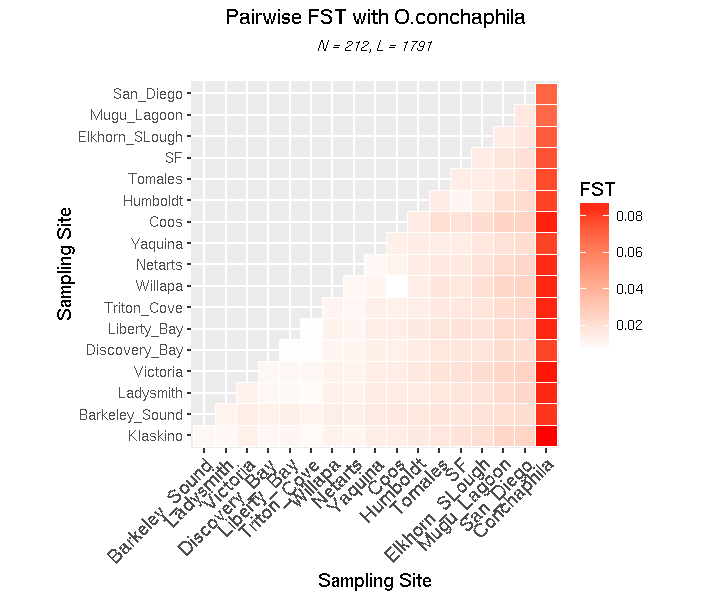

In [35]:
options(repr.plot.width=6,repr.plot.height=5)
ggplot(data = melted, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient(low = "white", high = "red", 
   name="FST")  + ggtitle(expression(atop("Pairwise FST with O.conchaphila", atop(italic("N = 212, L = 1791"), ""))))+
labs( x = "Sampling Site", y = "Sampling Site") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+ coord_fixed()

# Set title to twice the base font size
#p + theme(plot.title = element_text(size = rel(2)))

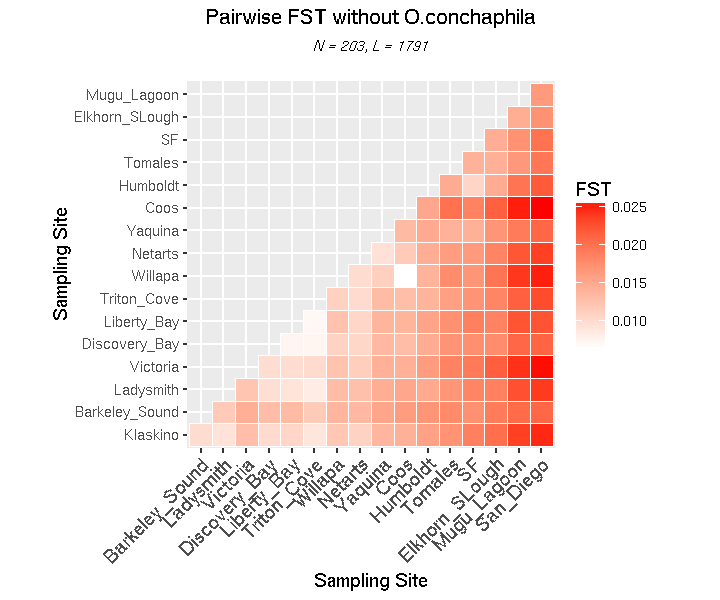

In [34]:
options(repr.plot.width=6,repr.plot.height=5)
ggplot(data = melted.noc, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient(low = "white", high = "red", 
   name="FST")  + ggtitle(expression(atop("Pairwise FST without O.conchaphila", atop(italic("N = 203, L = 1791"), ""))))+labs( x = "Sampling Site", y = "Sampling Site")+
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+ coord_fixed()

In [18]:
library(adegenet)
library(pegas)
library(hierfstat)

In [56]:
setwd("~/Projects/Ostrea/over10k-min75H32/north_south/")
pops <- c("North","South","Conchaphila")
suf <- "over10k-min75H32u"
print(pops)
fst.nsc.df <- data.frame(matrix(data=NA,nrow=length(pops),ncol=length(pops)))
rownames(fst.nsc.df) <- pops
colnames(fst.nsc.df) <- pops

pi.nsc.df <- data.frame(matrix(data=NA,nrow=length(pops),ncol=length(pops)))
rownames(pi.nsc.df) <- pops
colnames(pi.nsc.df) <- pops
popcombos <- unlist(combn(pops,2))
for(i in seq(1,length(popcombos), by = 2)){
    popsuf = paste(suf,popcombos[i],popcombos[i+1],sep="_")
    if(!file.exists(paste(popsuf,"geno",sep = "."))){
        popsuf = paste(suf,popcombos[i+1],popcombos[i],sep="_")}
    glist = makeGenoMatrix(paste(popsuf,"geno",sep = "."),paste(popsuf,"ind",sep="."))
    geno_matrix = glist[[1]]
    test_sub = glist[[2]]
    null_sub = glist[[3]]
    meanPi = getPi(geno_matrix,popsuf)
    meanFST = getCoverFst(geno_matrix, popsuf,test_sub, null_sub)
    fst.nsc.df[rownames(fst.nsc.df)==popcombos[i],popcombos[i+1]] <- meanFST
    pi.nsc.df[rownames(pi.nsc.df)==popcombos[i],popcombos[i+1]] <- meanPi
    getHW(geno_matrix,popsuf)
}
print("done")

[1] "North"       "South"       "Conchaphila"
[1] "done"


In [21]:
#write.csv(fst.nsc.df,file="over10k-min75H32u_NSC.pwFST")
setwd("~/Projects/Ostrea/over10k-min75H32/north_south/")
fst.nsc.df <- read.csv("over10k-min75H32u_NSC.pwFST")
fst.nsc.df

,X,North,South,Conchaphila
1,North,NA,0.00862126910786654,0.0820934036537975
2,South,NA,NA,0.062177186969967
3,Conchaphila,NA,NA,NA


## Plotting Results
Lets take a look at the North and South as populations.

In [22]:
## Create matricx with all data
pi = read.table("over10k-min75H32u_North_South.pi")
f_null = read.table("over10k-min75H32u_North_South.null_fst")
f_test = read.table("over10k-min75H32u_North_South.fst")
cover_test = read.table("over10k-min75H32u_North_South.genocover") 
af = read.table("over10k-min75H32u_North_South.af")
HW_chi = read.table("over10k-min75H32u_North_South.HW")
allele_class = read.table("over10k-min75H32u_North_South.AC")

FST_data = cbind(f_null,f_test,cover_test,pi,af,HW_chi,allele_class)
names(FST_data) = c("F_null","F_test","Cover","Pi","AF","HW","AC")
#names(FST_data) = c("F_null","F_test","Cover","Pi","AF","AC")

In [23]:
##SUBSETS FST DATA INTO COVERAGE GROUPS
for (i in min(cover_test):max(cover_test)){
    name = paste("FST_data_cover_",i, sep = "")
    assign(name,subset(FST_data, cover_test == i))
}
#SUBSETS FST DATA INTO GROUPS WITH FST > 0.1
FST_data_HT = subset(FST_data, F_test >= 0.1)
FST_data_HN = subset(FST_data, F_null >= 0.1)

#SUBSETS FST DATA INTO GROUPS WITH FST < 0.1
FST_data_LT = subset(FST_data, F_test < 0.1)
FST_data_LN = subset(FST_data, F_null < 0.1)

#SUBSETS FST DATA INTO GROUPS WITH Pi > 0.8 or < 0.2
Hi_Pi = subset(FST_data, Pi >= 0.8)
Lo_Pi = subset(FST_data, Pi < 0.2)

Pi_cat = cut(FST_data$Pi,breaks=10)

#SUBSETS FST DATA TO EXCLUDE SINGLETONS (AC == 1)
FST_data_AC = subset(FST_data, allele_class > 1)
FST_data_AC_HT = subset(FST_data_AC, F_test >0.1)
Hi_Pi_AC = subset(FST_data_AC, Pi >=0.8)
Lo_Pi_AC = subset(FST_data_AC, Pi <0.2)

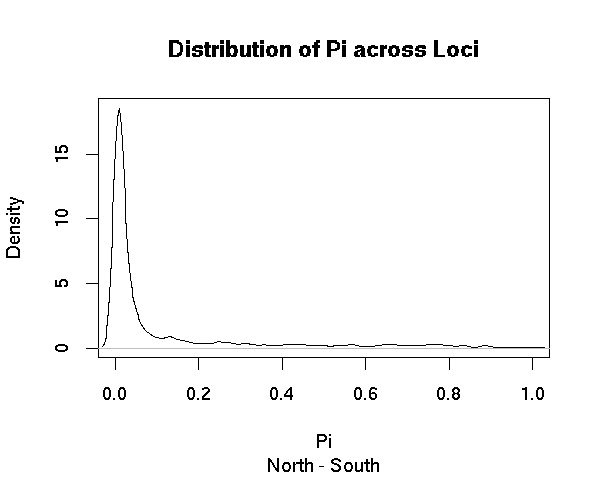

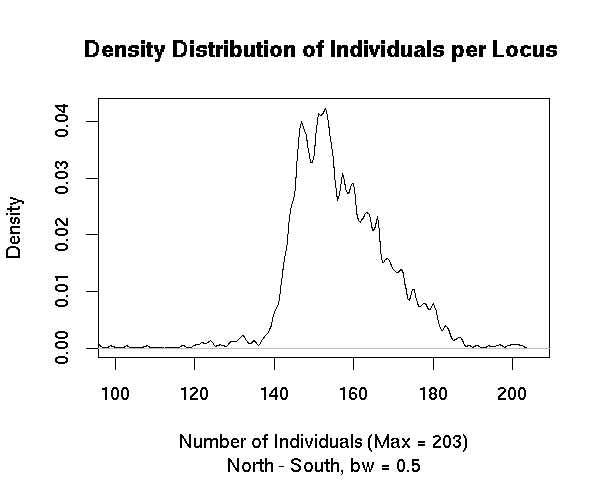

In [33]:
options(repr.plot.width=5,repr.plot.height=4)
#Plot densities of these values
plot(density(FST_data$Pi,bw=0.01, na.rm=TRUE),xlim=c(0,1),main="Distribution of Pi across Loci", xlab="Pi", sub="North - South")
plot(density(FST_data$Cover,bw=0.5),xlim=c(100,205),main="Density Distribution of Individuals per Locus ", xlab="Number of Individuals (Max = 203)",sub="North - South, bw = 0.5")


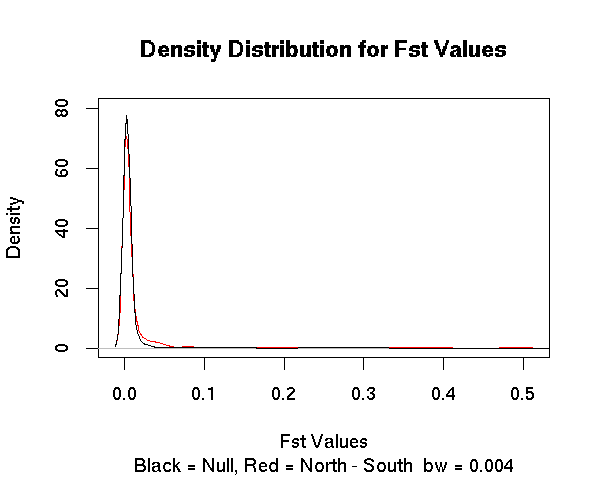

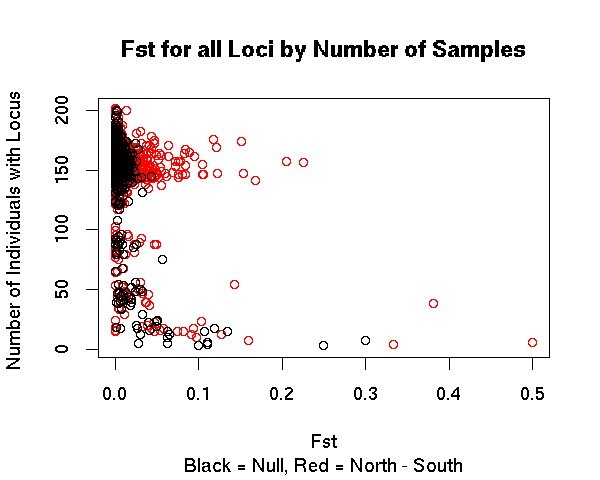

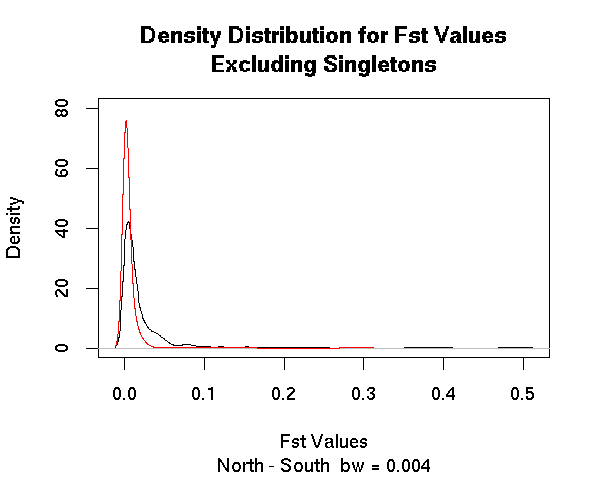

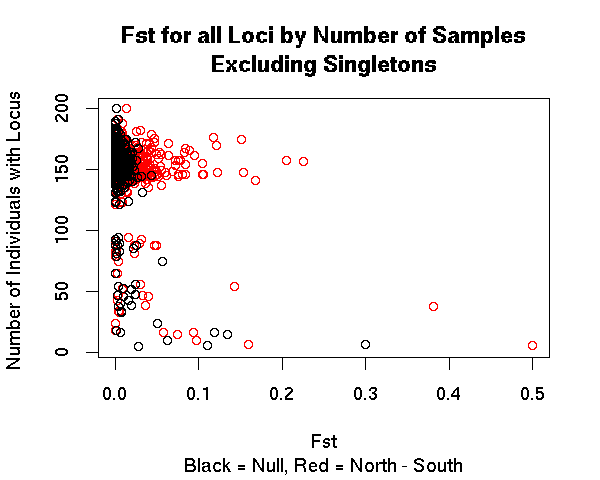

In [31]:
options(repr.plot.width=5,repr.plot.height=4)
##PLOT FST AGAINST GENO_COVER
plot(density(FST_data$F_test,na.rm=TRUE,bw=.004), col=2,ylim=c(0,80),main="Density Distribution for Fst Values",xlab="Fst Values", sub = "Black = Null, Red = North - South  bw = 0.004")
lines(density(FST_data$F_null,na.rm=TRUE,bw=.004))

plot(FST_data$F_test,FST_data$Cover,col=2,main="Fst for all Loci by Number of Samples",xlab="Fst",ylab="Number of Individuals with Locus ",sub="Black = Null, Red = North - South")
points(FST_data$F_null,FST_data$Cover)

plot(density(FST_data_AC$F_test,na.rm=TRUE,bw=.004),ylim=c(0,80),main="Density Distribution for Fst Values\nExcluding Singletons",xlab="Fst Values", sub = "North - South  bw = 0.004")
lines(density(FST_data_AC$F_null,na.rm=TRUE,bw=.004),col=2)

plot(FST_data_AC$F_test,FST_data_AC$Cover,col=2,main="Fst for all Loci by Number of Samples\nExcluding Singletons",xlab="Fst",ylab="Number of Individuals with Locus ",sub="Black = Null, Red = North - South")
points(FST_data_AC$F_null,FST_data_AC$Cover)

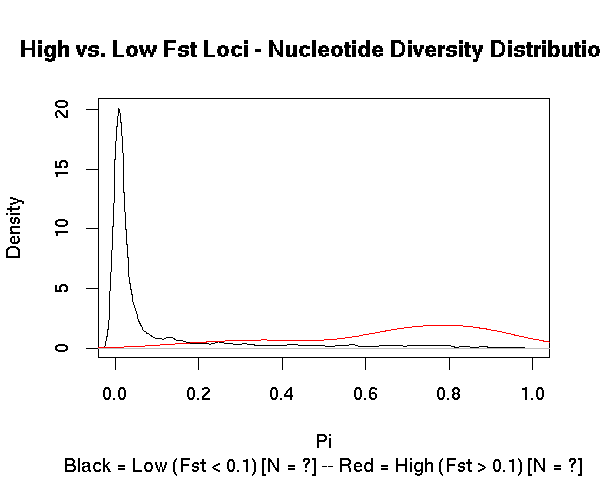

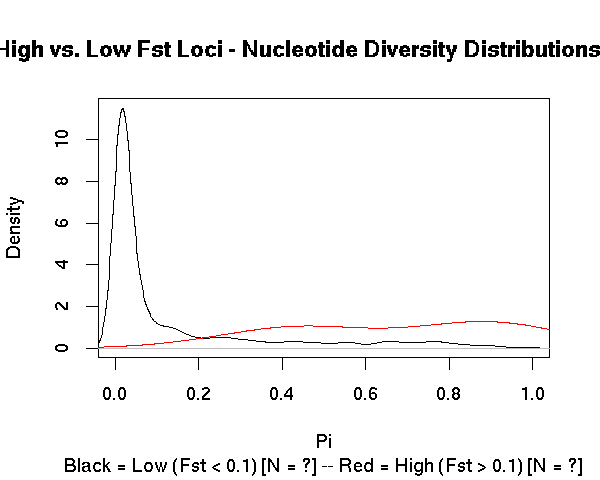

In [32]:
options(repr.plot.width=5,repr.plot.height=4)
#PLOTS NUCLEOTIDE DIVERSITY FOR HIGH VS. LOW FST LOCI
plot(density(FST_data_LT$Pi),main="High vs. Low Fst Loci - Nucleotide Diversity Distributions",xlim = c(0,1), 
     xlab="Pi",sub="Black = Low (Fst < 0.1) [N = ?] -- Red = High (Fst > 0.1) [N = ?]")
lines(density(FST_data_HT$Pi),col=2)

plot(density(FST_data_LN$Pi),main="High vs. Low Fst Loci - Nucleotide Diversity Distributions: Null",xlim = c(0,1), 
     xlab="Pi",sub="Black = Low (Fst < 0.1) [N = ?] -- Red = High (Fst > 0.1) [N = ?]")
lines(density(FST_data_HN$Pi),col=2)
#plot(density(FST_data_HN$Cover,bw=1),xlim=c(0,1))
#lines(density(FST_data_HT$Cover),col=2)

Warning message:
“Removed 5 rows containing missing values (geom_point).”

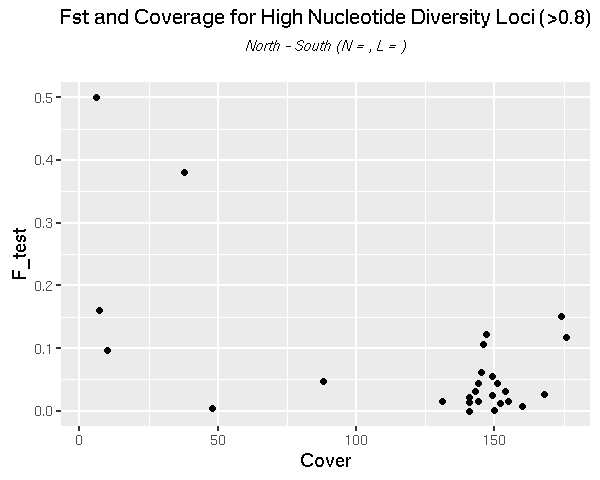

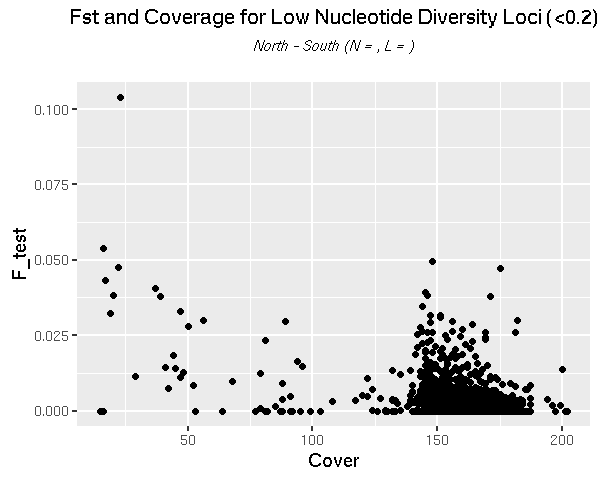

In [30]:
options(repr.plot.width=5,repr.plot.height=4)
##Plots LOW DIVERSITY AND HIGH DIVERSITY LOCI

HP = ggplot(Hi_Pi, aes(x = Cover, y = F_test))
HP + geom_point(alpha = 1) + ggtitle(expression(atop("Fst and Coverage for High Nucleotide Diversity Loci (>0.8)", atop(italic("North - South (N = , L = )", "")))))

HPAC = ggplot(Hi_Pi_AC, aes(x = Cover, y = F_test, color = variable))
HPAC + geom_point(alpha = 1) + ggtitle(expression(atop("Fst and Coverage for High Nucleotide Diversity Loci (>0.8)", atop(italic("AC > 1, North - South (N = , L = )", "")))))

HPlow = ggplot(Lo_Pi, aes(x = Cover, y = F_test))
HPlow + geom_point(alpha = 1) + ggtitle(expression(atop("Fst and Coverage for Low Nucleotide Diversity Loci (<0.2)", atop(italic("North - South (N = , L = )", "")))))



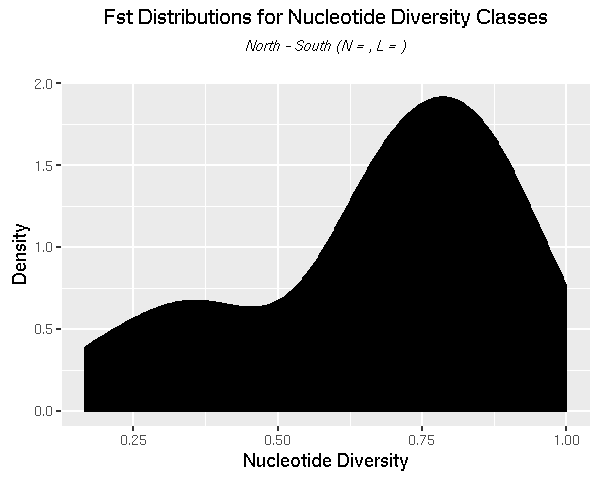

In [106]:
##PLOTS DENSITY DISTRIBUTION OF NUCLEOTIDE DIVERSITY FOR FST > 0.1
TOP_DENS = ggplot(FST_data_HT, aes(x = Pi))
TOP_DENS + geom_density(fill = "black") + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes", atop(italic("North - South (N = , L = )", ""))))) + labs(x = "Nucleotide Diversity", y = "Density")


Warning message:
“Removed 399 rows containing non-finite values (stat_boxplot).”

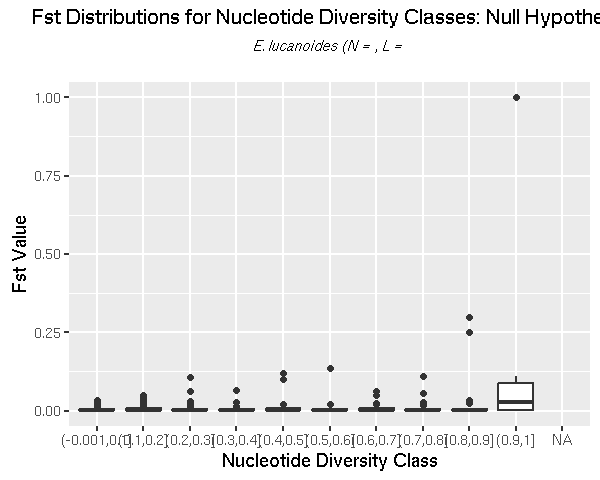

In [109]:
##GGPLOT NUCLEOTIDE DIVERSITY CLASSES AGAINST FST FOR NULL AND TEST
p = ggplot(FST_data, aes(factor(Pi_cat), F_null))

#p + geom_violin() + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes",
#atop(italic("E. burchellii (N = 75, L = 168,518)", ""))))) + 
#labs(x = "Nucleotide Diversity Class", y = "Fst Value")

p + geom_boxplot() + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes: Null Hypothesis", 
atop(italic("E. lucanoides (N = , L = ", ""))))) + labs(x = "Nucleotide Diversity Class", y = "Fst Value")


## North and Conchaphila

In [27]:
pi_nc = read.table("over10k-min75H32u_North_Conchaphila.pi")
f_null_nc = read.table("over10k-min75H32u_North_Conchaphila.null_fst")
f_test_nc = read.table("over10k-min75H32u_North_Conchaphila.fst")
cover_test_nc = read.table("over10k-min75H32u_North_Conchaphila.genocover") 
af_nc = read.table("over10k-min75H32u_North_Conchaphila.af")
HW_chi_nc = read.table("over10k-min75H32u_North_Conchaphila.HW")
allele_class_nc = read.table("over10k-min75H32u_North_Conchaphila.AC")

FST_data_NC = cbind(f_null_nc,f_test_nc,cover_test_nc,pi_nc,af_nc,HW_chi_nc,allele_class_nc)
names(FST_data_NC) = c("F_null","F_test","Cover","Pi","AF","HW","AC")

##SUBSETS FST DATA INTO COVERAGE GROUPS
for (i in min(cover_test_nc):max(cover_test_nc)){
    name = paste("FST_data_cover_",i, sep = "")
    assign(name,subset(FST_data_NC, cover_test_nc == i))
}
#SUBSETS FST DATA INTO GROUPS WITH FST > 0.1
FST_data_HT_NC = subset(FST_data_NC, F_test >= 0.1)
FST_data_HN_NC = subset(FST_data_NC, F_null >= 0.1)

#SUBSETS FST DATA INTO GROUPS WITH FST < 0.1
FST_data_LT_NC = subset(FST_data_NC, F_test < 0.1)
FST_data_LN_NC = subset(FST_data_NC, F_null < 0.1)

#SUBSETS FST DATA INTO GROUPS WITH Pi > 0.8 or < 0.2
Hi_Pi_NC = subset(FST_data_NC, Pi >= 0.8)
Lo_Pi_NC = subset(FST_data_NC, Pi < 0.2)

Pi_cat_NC = cut(FST_data_NC$Pi,breaks=10)

#SUBSETS FST DATA TO EXCLUDE SINGLETONS (AC == 1)
FST_data_AC_NC = subset(FST_data_NC, allele_class > 1)
FST_data_AC_HT_NC = subset(FST_data_AC_NC, F_test == 1)

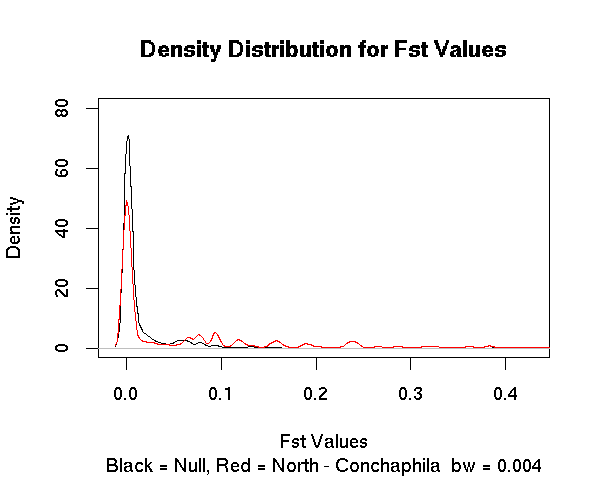

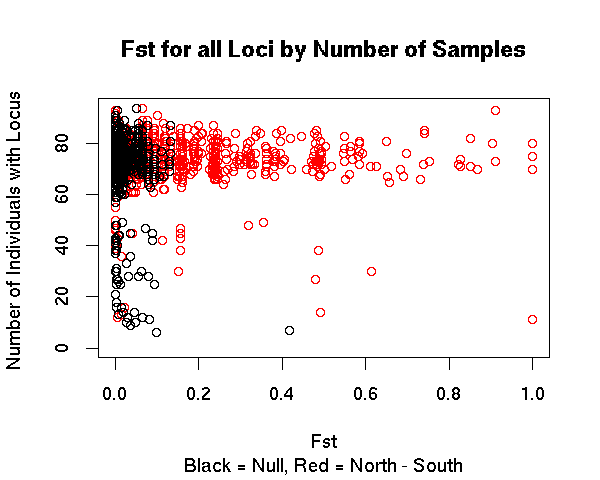

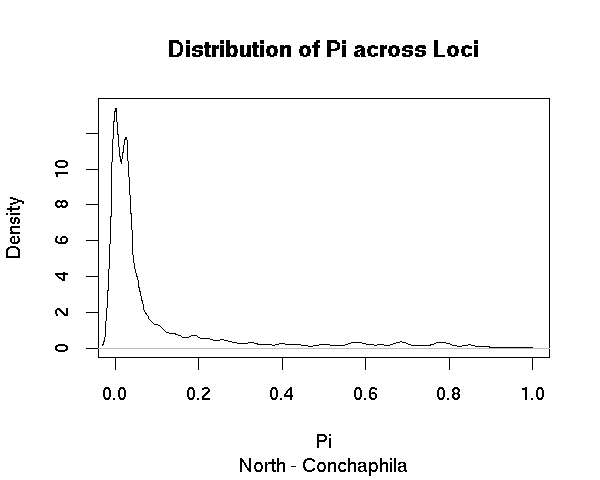

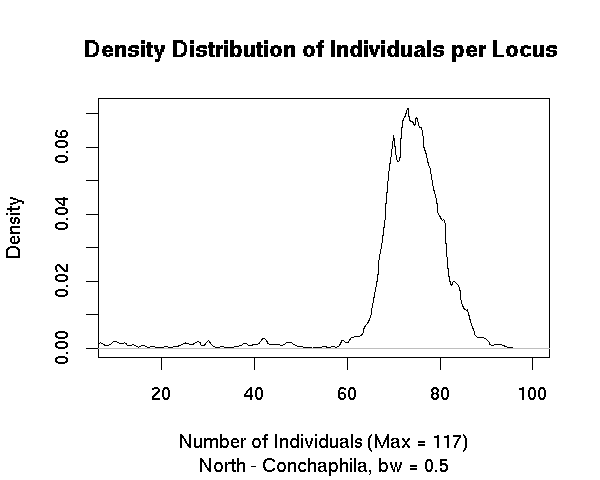

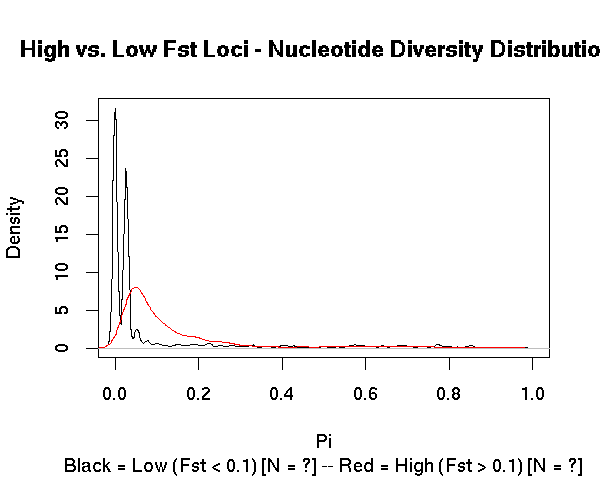

Warning message:
“Removed 595 rows containing non-finite values (stat_boxplot).”

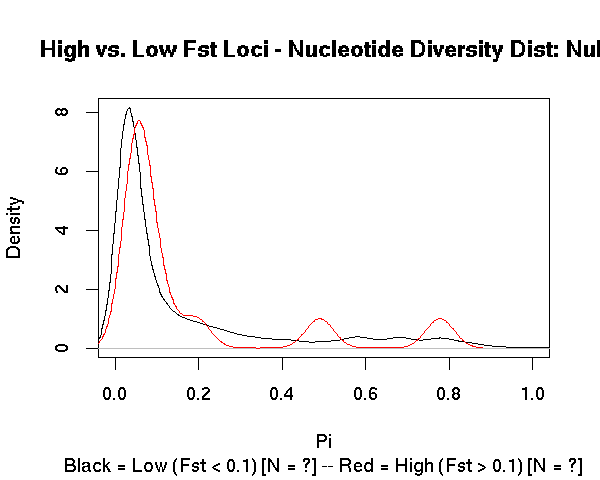

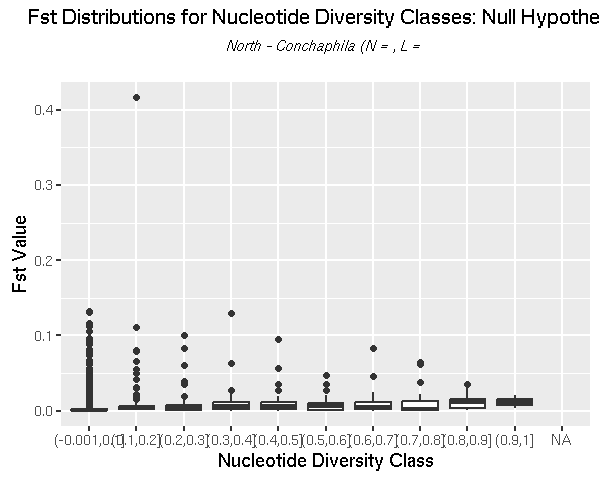

In [29]:
options(repr.plot.width=5,repr.plot.height=4)
##PLOT FST AGAINST GENO_COVER
plot(density(FST_data_NC$F_null,na.rm=TRUE,bw=.004),ylim=c(0,80),main="Density Distribution for Fst Values",xlab="Fst Values", sub = "Black = Null, Red = North - Conchaphila  bw = 0.004")
lines(density(FST_data_NC$F_test,na.rm=TRUE,bw=.004),col=2)

plot(FST_data_NC$F_test,FST_data_NC$Cover,col=2,main="Fst for all Loci by Number of Samples",xlab="Fst",ylab="Number of Individuals with Locus ",sub="Black = Null, Red = North - South")
points(FST_data_NC$F_null,FST_data_NC$Cover)

plot(density(FST_data_NC$Pi,bw=0.01, na.rm=TRUE),xlim=c(0,1),main="Distribution of Pi across Loci", xlab="Pi", sub="North - Conchaphila")
plot(density(FST_data_NC$Cover,bw=0.5),xlim=c(10,100),main="Density Distribution of Individuals per Locus ", xlab="Number of Individuals (Max = 117)",sub="North - Conchaphila, bw = 0.5")

plot(density(FST_data_LT_NC$Pi),main="High vs. Low Fst Loci - Nucleotide Diversity Distributions",xlim = c(0,1), 
     xlab="Pi",sub="Black = Low (Fst < 0.1) [N = ?] -- Red = High (Fst > 0.1) [N = ?]")
lines(density(FST_data_HT_NC$Pi),col=2)

plot(density(FST_data_LN_NC$Pi),main="High vs. Low Fst Loci - Nucleotide Diversity Dist: Null",xlim = c(0,1), 
     xlab="Pi",sub="Black = Low (Fst < 0.1) [N = ?] -- Red = High (Fst > 0.1) [N = ?]")
lines(density(FST_data_HN_NC$Pi),col=2)

p = ggplot(FST_data_NC, aes(factor(Pi_cat), F_null))

#p + geom_violin() + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes",
#atop(italic("E. burchellii (N = 75, L = 168,518)", ""))))) + 
#labs(x = "Nucleotide Diversity Class", y = "Fst Value")

p + geom_boxplot() + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes: Null Hypothesis", 
atop(italic("North - Conchaphila (N = , L = ", ""))))) + labs(x = "Nucleotide Diversity Class", y = "Fst Value")